Epoch 1/50
38/38 [==============================] - 62s 2s/step - loss: 0.4752 - accuracy: 0.7668 - val_loss: 0.9295 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 2/50


C:\Users\Abhinav Sharma\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 58s 2s/step - loss: 0.3880 - accuracy: 0.8182 - val_loss: 1.1578 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - 58s 2s/step - loss: 0.3837 - accuracy: 0.8359 - val_loss: 1.6500 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.8493
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
38/38 [==============================] - 58s 2s/step - loss: 0.3373 - accuracy: 0.8493 - val_loss: 1.0150 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 5/50
38/38 [==============================] - 58s 2s/step - loss: 0.3015 - accuracy: 0.8721 - val_loss: 1.9679 - val_accuracy: 0.5067 - lr: 2.0000e-04
Epoch 6/50
38/38 [==============================] - 57s 2s/step - loss: 0.3007 - accuracy: 0.8687 - val_loss: 2.2361 - val_accuracy: 0.5067 - lr: 2.0000e-04
Epoch 7/50
38/38 [==============================] - ETA: 0s - loss: 0.2672 - a

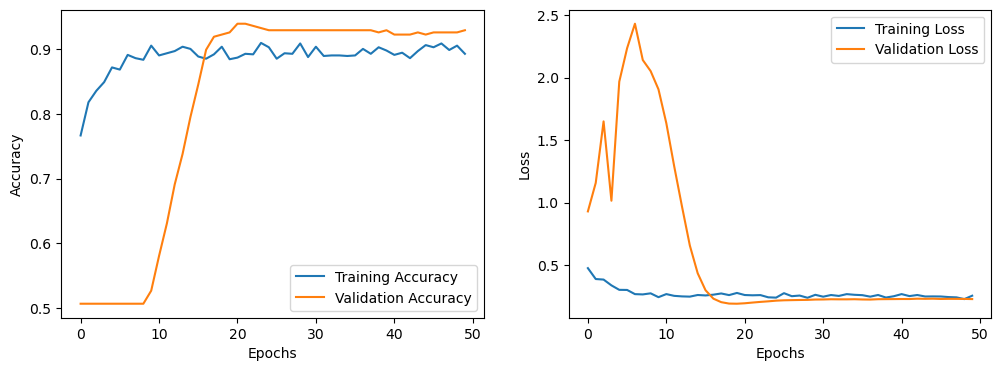

1/1 [==============================] - 0s 157ms/step
Predicted Class: Caries
Class Probabilities: [0.8919697  0.10803038]


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Preprocessing Functions
def preprocess_data(data_dir, image_size=(128, 128)):
    classes = os.listdir(data_dir)
    class_labels = {cls_name: idx for idx, cls_name in enumerate(classes)}

    images = []
    labels = []

    for cls_name in classes:
        cls_folder = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_folder):
            for img_file in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_file)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, image_size)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    labels.append(class_labels[cls_name])
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

    X = np.array(images, dtype="float32") / 255.0
    y = to_categorical(labels, num_classes=len(classes))

    return X, y

def split_dataset(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Model Building
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Paths to data
train_dir = r"\zz_oral\OA\TRAIN"
test_dir = r"\zz_oral\OA\TEST"

# Preprocess data
image_size = (128, 128)
X_train, y_train = preprocess_data(train_dir, image_size=image_size)
X_test, y_test = preprocess_data(test_dir, image_size=image_size)

# Split training data
X_train, X_val, y_train, y_val = split_dataset(X_train, y_train)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Build and compile the model
input_shape = (image_size[0], image_size[1], 3)
num_classes = y_train.shape[1]

model = build_model(input_shape, num_classes)

optimizer = optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define Callbacks
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[checkpoint, lr_schedule]
)

# Evaluate the model
model.load_weights("best_model.h5")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot Metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

# Save the trained model in Keras format
model.save("oral_disease_classifier.keras")

# Predict on Test Data
def predict_image(model, image_path, image_size=(128, 128), class_labels=None):
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img / 255.0, axis=0)

    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)

    if class_labels:
        return class_labels[predicted_class], predictions[0]
    return predicted_class, predictions[0]

# Example usage:
class_labels = {0: "Caries", 1: "Gingivitis"}
example_image_path = "\zz_oral\OA\TEST\Caries\caries_0_7_1.jpg"
predicted_class, probabilities = predict_image(model, example_image_path, image_size, class_labels)
print(f"Predicted Class: {predicted_class}")
print(f"Class Probabilities: {probabilities}")
